# Download requirements

In [ ]:
install.packages('fpp2')

In [1]:
library(fpp2)

Warning message:
"package 'fpp2' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
-- Attaching packages ---------------------------------------------- fpp2 2.4 --
v ggplot2   3.1.1     v fma       2.4  
v forecast  8.14      v expsmooth 2.3  
Warning message:
"package 'forecast' was built under R version 3.6.3"Warning message:
"package 'fma' was built under R version 3.6.3"Warning message:
"package 'expsmooth' was built under R version 3.6.3"


# Load dataset

In [2]:
data <- read.csv('Data.csv')

In [3]:
summary(data)

      Date            Mkt.RF              SMB                HML         
 Min.   :196307   Min.   :-23.2400   Min.   :-15.3900   Min.   :-13.920  
 1st Qu.:197803   1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -1.395  
 Median :199212   Median :  0.9250   Median :  0.1050   Median :  0.230  
 Mean   :199248   Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.300  
 3rd Qu.:200708   3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.700  
 Max.   :202204   Max.   : 16.1000   Max.   : 18.3800   Max.   : 12.740  
      RMW                CMA                RF             NoDur        
 Min.   :-18.7600   Min.   :-6.7800   Min.   :0.0000   Min.   :-21.020  
 1st Qu.: -0.8175   1st Qu.:-1.0000   1st Qu.:0.1400   1st Qu.: -1.242  
 Median :  0.2400   Median : 0.1100   Median :0.3800   Median :  1.080  
 Mean   :  0.2752   Mean   : 0.2947   Mean   :0.3641   Mean   :  1.049  
 3rd Qu.:  1.2775   3rd Qu.: 1.4900   3rd Qu.:0.5100   3rd Qu.:  3.720  
 Max.   : 13.3800   Max.   : 9.0600   Max.  

# Predict cho Other portfolio

#### Lấy dữ liệu của Other porfolio

In [4]:
series <- ts(data = data$Other, start = c(1963,7), end = c(2022,4), frequency = 12)

In [5]:
series %>% summary()

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-23.6000  -2.0400   1.3650   0.9452   4.1250  20.2400 

#### Khảo sát tập train từ 7/1963 - 12/1989

In [6]:
log_scale <- function(x) {log(1+x/100)} #scaler
log_inv <- function(x) {(exp(x)-1)*100} #inverter

In [7]:
series_train <- series %>% window(end=c(1989,12)) %>% log_scale

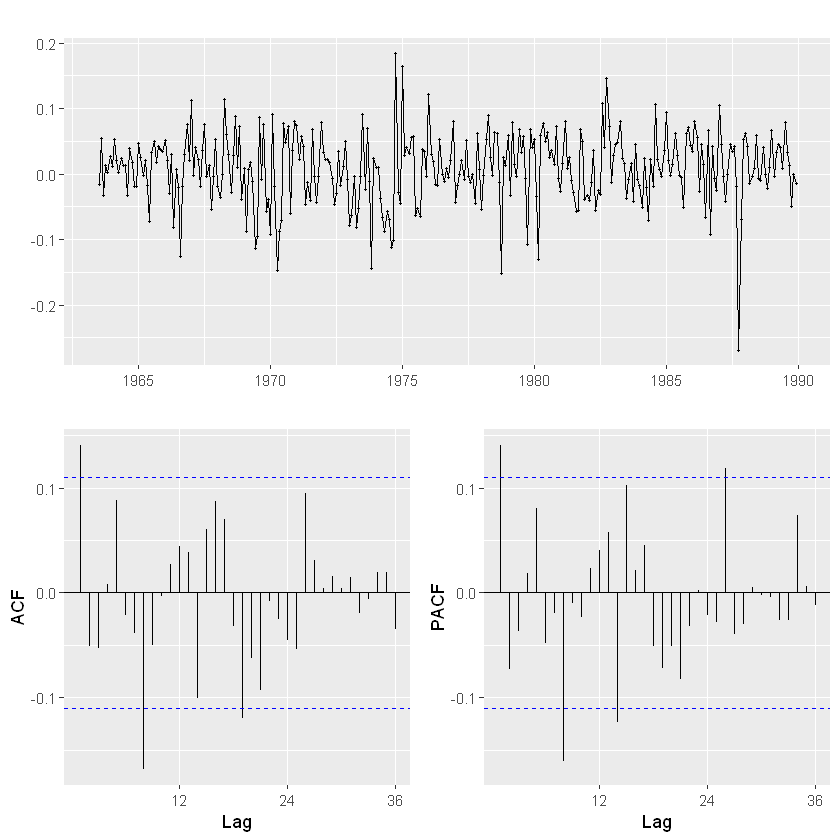

In [8]:
series_train %>% ggtsdisplay()

Biểu đồ dao động không có trend và seasonality quan sát được, nên không cần lấy difference và seasonal difference. <br>
Thử lại với hàm dò tìm bậc d: ndiffs cho order và nsdiffs cho seasonal.

In [9]:
series_train %>% ndiffs()

[1] 0

In [10]:
series_train %>% nsdiffs()

[1] 0

Kết quả d = 0 cho cả order và seasonal.

#### Phân tích p và q cho mô hình ARIMA

Thử dò tìm (p,d,q) với chế độ auto theo thuật toán Hyndman-Khandakar.

In [11]:
fit <- auto.arima(series_train, stepwise = FALSE, approximation = FALSE)
fit

Series: series_train 
ARIMA(0,0,1) with non-zero mean 

Coefficients:
         ma1    mean
      0.1566  0.0086
s.e.  0.0571  0.0035

sigma^2 estimated as 0.002869:  log likelihood=480.53
AIC=-955.06   AICc=-954.99   BIC=-943.78


	Ljung-Box test

data:  Residuals from ARIMA(0,0,1) with non-zero mean
Q* = 32.098, df = 22, p-value = 0.07574

Model df: 2.   Total lags used: 24



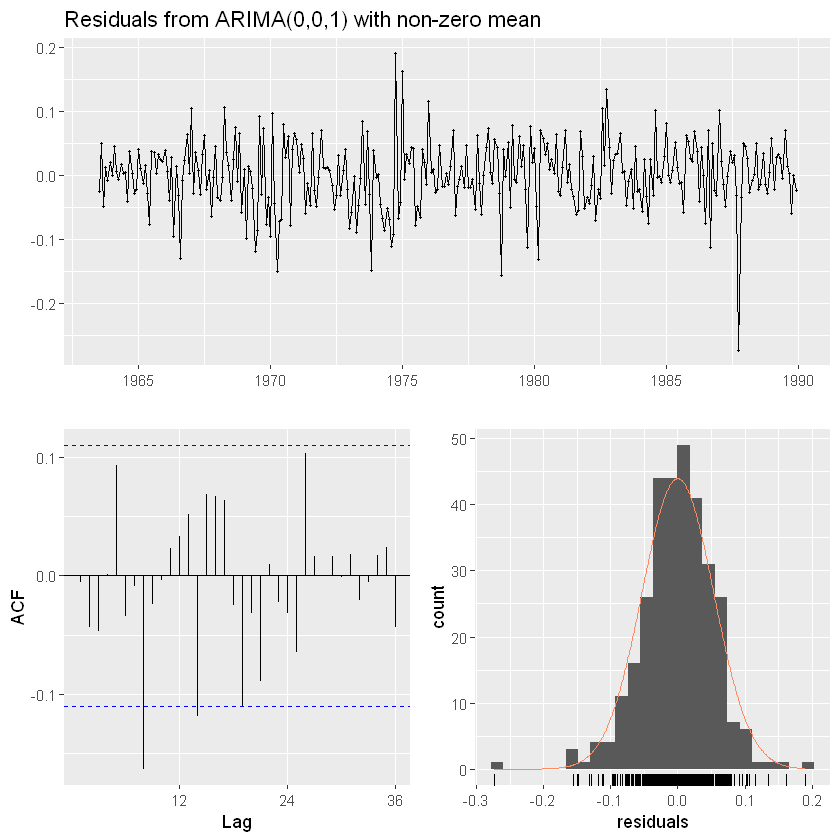

In [12]:
fit %>% checkresiduals()

Auto đề xuất ARIMA(0,0,1), Ljung-Box test cho p-value > 0.05 nên mô hình phù hợp.

Thử tất cả các mô hình đề xuất và so sánh theo tiêu chuẩn thông tin AIC, AICc, BIC, RMSE.

In [13]:
model <- list(ARIMA000 = c(0,0,0), ARIMA001 = c(0,0,1), ARIMA002 = c(0,0,2), ARIMA100 = c(1,0,0), ARIMA101 = c(1,0,1), 
              ARIMA102 = c(1,0,2), ARIMA200 = c(2,0,0), ARIMA201 = c(2,0,1), ARIMA202 = c(2,0,2))

In [14]:
result <- NULL
for (m in model)
{
    fit <- Arima(series_train, order = m)
    fitted <- ts(data = fit$fitted, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
    rmse <- sqrt(mean((log_inv(series_train) - fitted)^2))
    result <- rbind(result, c(AIC = fit$aic, AICc = fit$aicc, BIC = fit$bic, RMSE = rmse))
}
row.names(result) <- names(model)
result

,AIC,AICc,BIC,RMSE
ARIMA000,-949.9103,-949.8722,-942.3862,5.381782
ARIMA001,-955.0624,-954.9860,-943.7763,5.329227
ARIMA002,-953.5335,-953.4057,-938.4853,5.324683
ARIMA100,-954.2758,-954.1994,-942.9896,5.335066
ARIMA101,-953.3614,-953.2336,-938.3132,5.326483
ARIMA102,-952.4787,-952.2864,-933.6684,5.313733
ARIMA200,-953.9648,-953.8370,-938.9166,5.320989
ARIMA201,-952.1712,-951.9789,-933.3610,5.318844
ARIMA202,-951.7522,-951.4821,-929.1799,5.304376


Mô hình ARIMA(2,0,2) cho kết quả RMSE thấp nhất trên tập train.

#### Đánh giá mô hình ARIMA(2,0,2) trên tập test

In [7]:
pred <- NULL
for (i in 0:387)
{
    train <- series %>% subset(end = length(series)-388+i) %>% log_scale
    fit <- Arima(train, order = c(2,0,2))
    pred <- c(pred, forecast(fit, h = 1)$mean %>% log_inv) 
}
pred <- ts(data = pred, start = c(1990,1), frequency = 12)
true <- series %>% window(start = c(1990,1))
rmse <- sqrt(mean((true-pred)^2))
rmse

[1] 5.272055

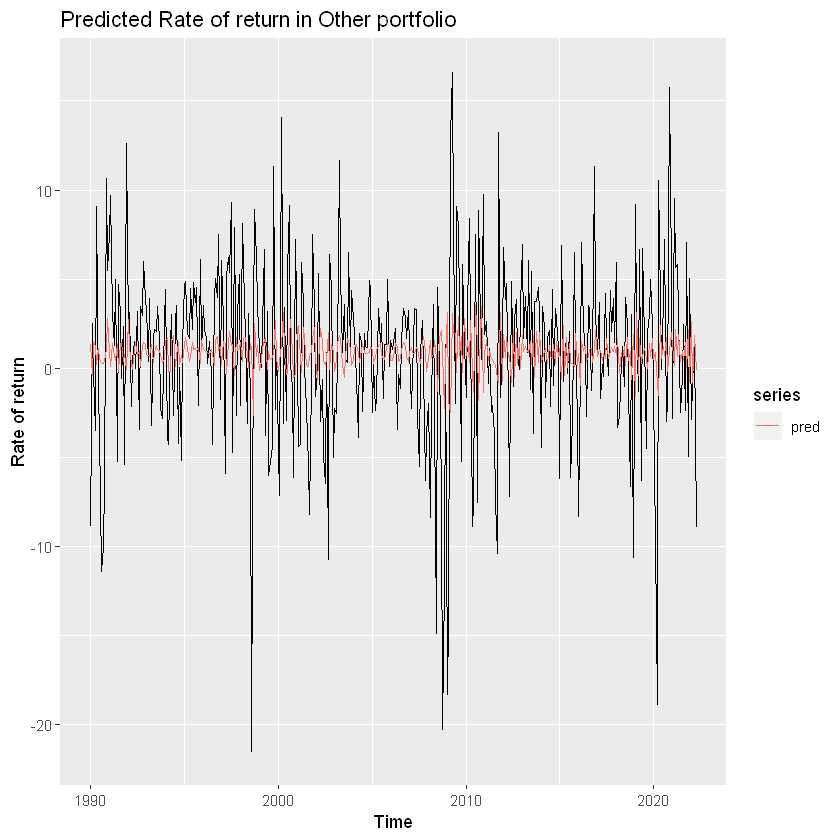

In [8]:
autoplot(true) + autolayer(pred) + labs(y = "Rate of return", title = "Predicted Rate of return in Other portfolio")

In [9]:
as.numeric(pred)

[1]  1.32749623 -0.42934367  1.50829436  1.28271655  0.19496254  1.12790617
  [7]  0.52447364  0.34270848  0.24422462  0.37129739  1.08829908  2.79012236
 [13]  0.98304559  0.09561190  1.36497061  0.73891011  0.45856113  1.37369432
 [19] -0.15756406  1.39330732  1.46396097  0.36020352  0.76115468 -0.05055845
 [25]  2.72601259  1.11226884  0.27726936 -0.03847452  1.06003554  1.45419544
 [31]  0.73458525  0.92344308  0.12811343  1.29134253  1.43290218  1.35524826
 [37]  0.77646488  0.72156651  0.64989110  1.35219890  0.34369643  0.89882069
 [43]  1.27789327  1.06128256  1.01192676  0.77990596  0.30069809  0.47155384
 [49]  1.57533809  1.65483742 -0.15971047 -0.17905993  1.54718903  1.83661476
 [55]  0.12262087  0.72982386  1.42239735  0.18687208  0.69917718  0.33291171
 [61]  1.31434614  1.70414531  1.13943546  0.39101961  0.64085474  1.47658292
 [67]  1.06687205  1.10707834  0.97592440  1.14280454  0.25003267  1.55180876
 [73]  1.05956549  1.00358948  0.87115303  0.90283091  0.79478020  1.03075012
 [79]  0.80180205  0.16963071  1.53926194  1.80443437  0.99745075  1.23915643
 [85]  0.16745482  1.48004519  1.37541185 -0.28154179  1.45167874  2.09277178
 [91]  1.26898244  1.36045323 -0.39861268  1.72825973  0.98252119  1.11889471
 [97]  1.43850403  0.40417664  1.65114880  1.71018005  0.70968399  0.01167584
[103]  1.41104249  1.18019206 -2.64980869  2.52616932  0.64902946  1.28656857
[109] -0.10439675  0.35843069  1.14809406  1.57511883  1.71772334 -0.08610657
[115]  0.96552647  0.50728429  0.62008479  0.83598294  2.70090937  0.53652915
[121] -0.19377827  0.39541870  1.30259844  3.14306460  0.89633847 -0.35070690
[127] -0.31034481  1.71673879  2.71728287  0.97165681 -0.51283498 -0.33376897
[133]  2.20771726  2.37913301  0.62858835 -0.23420136  2.28994885  1.69048432
[139]  0.16256321  0.13018932  0.63676689  0.86091594  1.67268385  2.27438954
[145]  0.53750349 -0.69775596  0.33552648  2.21875843  1.50374560  0.42815233
[151]  0.21966419  0.50217742  2.00760444 -0.05120916  1.40715310  0.93023386
[157] -0.16610937  0.43595097  1.41691399  1.81412598  1.68872679  0.20209933
[163] -0.51921956  0.69503709  1.66318402  1.55001870  1.11483884  0.14904641
[169]  0.47507889  1.09440066  1.33586818  0.86787967  0.35009930  1.00164177
[175]  1.37269834  0.88415255  0.82922534  0.82096598  0.89546063  1.21994093
[181]  1.06089858  0.31589137  0.61204010  1.01044436  1.27114311  1.39124035
[187]  0.80052741  0.52956619  0.46802311  1.13237669  1.39726963  1.28387332
[193]  0.44393036  0.42384453  0.93160713  1.37381542  1.21390887  0.37210705
[199]  0.55112089  1.05079012  1.46838427  1.26355325  0.65878223  0.39621266
[205]  0.89361768  1.16496956  0.86297136  0.83312485  1.14696105  1.12876209
[211]  0.45989449  0.24374089  1.33669739  1.80020146  0.93894992 -0.18167716
[217]  0.53572191  1.55666066  0.60390267  0.79545441  1.57877584  0.57418285
[223] -1.27677738  1.72698317  2.14095163  0.83643460 -2.25581497  0.46993807
[229]  3.15525490 -1.85381817 -2.47181254  3.07000613  1.95593182  1.98134276
[235] -0.25648842  2.93203121  0.71590611  1.81260394 -0.22622995  2.79984171
[241]  0.69893699  1.53278717  0.31042409  2.70688343 -0.11885904 -1.33253184
[247]  3.50059005  1.34458372 -1.83188147  2.08569574  3.44984732 -1.37409725
[253]  0.80564282  1.57033618  0.41443563  0.96258103  0.52487533  0.50304121
[259]  0.28912104  0.22684348 -0.56571234 -0.79168683  3.10742748 -0.74981404
[265]  1.90174330  0.62167094  1.80203812  0.66902499  0.73807113 -0.79858663
[271]  2.18742730 -0.48662816  2.02509233  0.24328375  1.45980987 -0.03079871
[277]  1.83971877  0.94513117  1.19872555  0.94413128  0.89327747  1.49124753
[283]  0.21874675  1.86518843 -0.51124206  2.04360016  0.32516681  2.03463634
[289]  0.31858399  0.55194737  0.95995795  1.11010431  0.24581919  1.25937278
[295]  0.65597767  0.54808139  1.34278905  0.28146180  1.50428516  0.66694034
[301]  1.12798055 -0.60276130  2.41597533 -0.42405400  1.74138857  0.05156705
[307]  1.39792194  0.321